## Lab 8. Topic 3. Deep Neural Networks
## Convolutional Networks

In this Lab we will focus on two different questions related to CNNs.

1) How to use an CNN that has been already trained to solve ML tasks?

2) How to design and train an CNN to solve a ML task ? 

We will use material from the book "Hands-On Machine Learning with Scikit-Learn and TensorFlow. Concepts, Tools, and Techniques to Build Intelligent Systems" by Aurélien Géron. http://shop.oreilly.com/product/0636920052289.do that it is recommended as Bibliography of the course.

In [113]:
# We start by importing the python libraries required to solve the problems

import numpy as np
import numpy.random as rnd
import itertools 
import os
import sys
import scipy.misc

# We used some utilities from sklearn
from sklearn.preprocessing import StandardScaler


# Tensorflow library used for implementation of the DNNs
import tensorflow as tf


# Used for plotting and display of figures
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12


from IPython.display import display
from IPython.display import Image
from IPython.display import SVG

The following functions serve to display RBB images

In [114]:
def plot_image(image):
    plt.imshow(image, cmap="gray", interpolation="nearest")
    plt.axis("off")

def plot_color_image(image):
    plt.imshow(image.astype(np.uint8),interpolation="nearest")
    plt.axis("off")

In [115]:
# This function set the seeds of the tensorflow function
# to make this notebook's output stable across runs

def reset_graph(seed=42):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)

# TODO

## Train the Convolutional Neural Network

#### We did not train the CNN in class; instead, we downloaded a pre-trained model of one

The way we can upload the model is by creating a tensorflow model with the same characteristics of the inception_v3 model and then uploading the file and plugging it to the created model. We do this in the next cell.
It is important to notice that the inception_v3 model considers images of size 299x299. Therefore we will need to resize the images in order to be classified by the model. This is explained later.

In [119]:
# We read the inception module from tensorflow
from tensorflow.contrib.slim.nets import inception
# The slim library within tensorflow (different to TFSlim)
# contains different modules already implemented
import tensorflow.contrib.slim as slim

reset_graph()

# The inputs will be images of size 299x299 in three color channels
X = tf.placeholder(tf.float32, shape=[None, 299, 299, 3], name="X")

with slim.arg_scope(inception.inception_v3_arg_scope()):
    # The model is defined, there are 1001 classes in the definition since one corresponds 
    # to noise or other, and is used only for training.
    logits, end_points = inception.inception_v3(X, num_classes=1001, is_training=False)
    
predictions = end_points["Predictions"]

# A saver is defined to load the model
saver = tf.train.Saver()

# The model is loaded
with tf.Session() as sess:
    saver.restore(sess, INCEPTION_V3_CHECKPOINT_PATH)
    # ...

INFO:tensorflow:Restoring parameters from datasets/inception/inception_v3.ckpt


Since images need to be resized to 299x299 we will need a program that does this. The following program does this work.

In [120]:
from scipy.misc import imresize

def prepare_image(image, target_width = 299, target_height = 299, max_zoom = 0.2):
    """Zooms and crops the image randomly for data augmentation."""

    # First, let's find the largest bounding box with the target size ratio that fits within the image
    height = image.shape[0]
    width = image.shape[1]
    image_ratio = width / height
    target_image_ratio = target_width / target_height
    crop_vertically = image_ratio < target_image_ratio
    crop_width = width if crop_vertically else int(height * target_image_ratio)
    crop_height = int(width / target_image_ratio) if crop_vertically else height
        
    # Now let's shrink this bounding box by a random factor (dividing the dimensions by a random number
    # between 1.0 and 1.0 + `max_zoom`.
    resize_factor = np.random.rand() * max_zoom + 1.0
    crop_width = int(crop_width / resize_factor)
    crop_height = int(crop_height / resize_factor)
    
    # Next, we can select a random location on the image for this bounding box.
    x0 = np.random.randint(0, width - crop_width)
    y0 = np.random.randint(0, height - crop_height)
    x1 = x0 + crop_width
    y1 = y0 + crop_height
    
    # Let's crop the image using the random bounding box we built.
    image = image[y0:y1, x0:x1]

    # Let's also flip the image horizontally with 50% probability:
    if np.random.rand() < 0.5:
        image = np.fliplr(image)

    # Now, let's resize the image to the target dimensions.
    image = imresize(image, (target_width, target_height))
    
    # Finally, let's ensure that the colors are represented as
    # 32-bit floats ranging from 0.0 to 1.0 (for now):
    return image.astype(np.float32) / 255



To test that the program that resizes the image works, modify the directory and the name of the image file in the cell below and read an image from your own directory. 

Notice that if the image is much larger and 299x299 the resizing program may select a different patch is time it is run. 

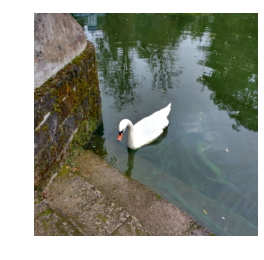

In [121]:
import matplotlib.image as mpimg
width = 299
height = 299
channels = 3


# Reads the desired image from the specified directory
name_of_img = " "
Im1 = mpimg.imread(os.path.join("images","name_of_img"))[:, :, :channels]
#Im1 = mpimg.imread(os.path.join("cnn_images","CotorrasYPapagallos-Curitiba.jpg"))[:, :, :channels]

# Creates new image
new_image = prepare_image(Im1, target_width = width, target_height = height, max_zoom = 0.2)  

# Shows the image
plt.imshow(new_image)
plt.axis("off")
plt.show()



Now we use the inception network for predicting the class of the photograph. The output of the network will be a vector of 1000 probabilities. We assign the picture to the class of highest probability (even if this probability can be small). 

In [122]:
# We transform the image to a tensorflow representation 
# Remember that since the pictures have 3 channels the inputs
# to the network are actually 3 matrices

X_test = new_image.reshape(-1, height, width, channels)

# Predictions are evaluated
with tf.Session() as sess:
    saver.restore(sess, INCEPTION_V3_CHECKPOINT_PATH)
    predictions_val = predictions.eval(feed_dict={X: X_test})
    
# The most likely class is the one with the highest prob.
most_likely_class_indices = (-predictions_val[0]).argsort()

most_likely_names = []
# We create a list with class names corresponding to the predictions indices
for i in np.arange(5):
   most_likely_names.append(class_names[most_likely_class_indices[i]])

print("The most likely five classes for this picture are", most_likely_names)

INFO:tensorflow:Restoring parameters from datasets/inception/inception_v3.ckpt
The most likely five classes for this picture are ['daisy', 'goose', 'spoonbill', 'albatross, mollymawk', 'American egret, great white heron, Egretta albus']


We can also plot the probabilities assigned to each class. 

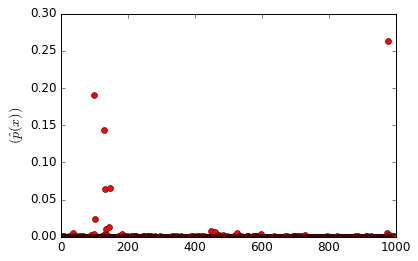

In [123]:
fsize = 14
fig = plt.figure()   
plt.plot(predictions_val[0,:],'ro', lw=4)
plt.ylabel(r'$(\hat{p}(x))$', fontsize=fsize)
plt.show()     

## Exercise 1

- Modify the image filename  in the FOLLOWING CELL so you could evaluate the variability and accuracy in the output of the network for different pictures. You do not have to implement ANYTHING in this exercise, only change the filenames to assess the accuracy of the network when detecting the contents of your pictures.


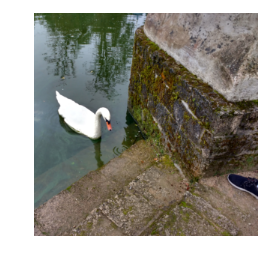

INFO:tensorflow:Restoring parameters from datasets/inception/inception_v3.ckpt
The most likely five classes for this picture are ['daisy', 'albatross, mollymawk', 'American egret, great white heron, Egretta albus', 'spoonbill', 'broom']


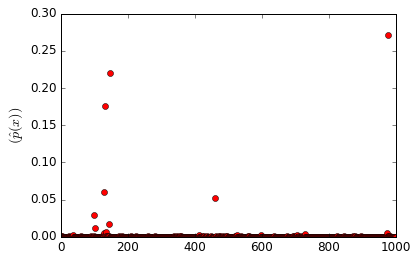

In [124]:
width = 299
height = 299
channels = 3


# Reads the desired image from the specified directory
#Im1 = mpimg.imread(os.path.join("cnn_images","CAM06487.jpg"))[:, :, :channels]
Im1 = mpimg.imread(os.path.join("images","IMG_20170908_071906090_HDR.jpg"))[:, :, :channels]

# Creates new image
new_image = prepare_image(Im1, target_width = width, target_height = height, max_zoom = 0.2)  

# Shows the image
plt.imshow(new_image)
plt.axis("off")
plt.show()


# We transform the image to a tensorflow representation 
X_test = new_image.reshape(-1, height, width, channels)

# Predictions are evaluated
with tf.Session() as sess:
    saver.restore(sess, INCEPTION_V3_CHECKPOINT_PATH)
    predictions_val = predictions.eval(feed_dict={X: X_test})
    
# The most likely class is the one with highest prob.
most_likely_class_indices = (-predictions_val[0]).argsort()

most_likely_names = []
# We output the class names
for i in np.arange(5):
   most_likely_names.append(class_names[most_likely_class_indices[i]])

print("The most likely five classes for this picture are", most_likely_names)


fsize = 14
fig = plt.figure()   
plt.plot(predictions_val[0,:],'ro', lw=4)
plt.ylabel(r'$(\hat{p}(x))$', fontsize=fsize)
plt.show()     





## Exercise 2

- Create a visual representation in two or three dimensions of all the pictures contained in your folder, where closer pictures in the representation are suppossed to have a similar content.


Suggestion 1: Create a list of all image filenames in you folder (number_pictures<=100)


Suggestion 2: Create a dataarray with the predictions of the network for each image file. It will have "number_pictures" rows and 1000 columns.

Suggestion 3: Apply dimensionality reduction on your dataarray to obtain only two dimensions for each picture (you can use sklearn function: http://scikit-learn.org/stable/modules/unsupervised_reduction.html

Suggestion 4: Plot the points (You can use the same plot function used in the previous cell or use a more sophisticated function from https://bokeh.pydata.org/en/latest/docs/gallery/color_scatter.html 


In [125]:
# files = [f for f in listdir(mypath) if isfile(join(mypath, f))]
# data_array = np.zeros

## Comment about Exercise 2



There is a follow up to Exercise 2 in Exercise 5, but first it is important to know CNNs are implemented.

## Convolutions and the Convolutional Layer

We start by discussing the building blocks of convolutional networks as implemented in tensorflow. 

The  function tf.nn.conv2d() computes a 2-D convolution given 4-D tensor, it receives as parameters:

- The input data of the layer (the output of the previous layer)
- A set of filters 
- The strides information for the application of those filters
- The padding scheme used with those filters


We will explain all these components and use two images to illustrate how they work. 


The first image is one of the Chillida scultures

In [126]:
# The image is loaded
image_C = scipy.misc.imread('cnn_images/Chillida.png', flatten=False, mode='RGB')

# We get the size and number of channels of the image
height, width, channels = image_C.shape
print("Characteristcs of the image (height, width, channels):", height, width, channels)




Characteristcs of the image (height, width, channels): 180 270 3


The image is transformed to grayscale (only one channel)

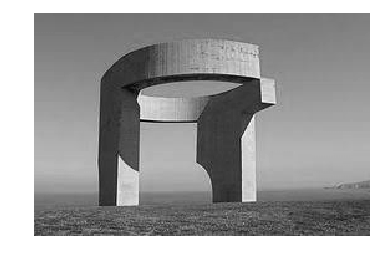

In [127]:
image_grayscale = image_C.mean(axis=2).astype(np.float32)
plot_image(image_grayscale)
plt.show()

# We reshape the image to a matrix on only two dimensions
images = image_grayscale.reshape(1, height, width, 1)

Now we will manually create two filters. Remember that in a convolutional network, the user specifies the size of the filters but the contents of the filters are learned as part of the NN learning process. Tensorflow defines a set of filters as a tensor of four dimensions:

1. Height 
2. Width 
3. Input Channels
4. Output Channels

where usually the Height and Width of the kernel are equal, and the same kernels are applied to all the channels. The number of Output Channels is the number of kernels we want to define. See the example below.


In [128]:
# We define 2 kernels of size 7x7 for the only channel we have (grayscale image)
fmap = np.zeros(shape=(7, 7, 1, 2), dtype=np.float32)

# We set the first kernel to be a vertical line (the third column of the kernel will be one)
# and four point in each image corner 
fmap[:, 3, 0, 0] = -1
fmap[0, 6, 0, 0] = 1
fmap[6, 0, 0, 0] = 1
fmap[0, 0, 0, 0] = 1
fmap[6, 6, 0, 0] = 1

# We set the second kernel to be a horizontal line (the third row of the kernel will be -1) 
# plus a vertical line (value 1)
fmap[:, 3, 0, 1] =  1
fmap[3, :, 0, 1] = -1


The two kernels are shown

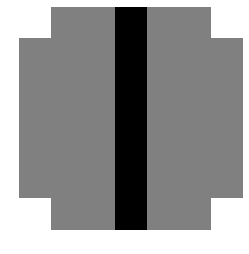

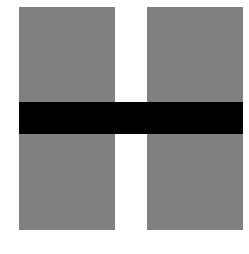

In [129]:
plot_image(fmap[:, :, 0, 0])
plt.show()
plot_image(fmap[:, :, 0, 1])
plt.show()

We define now the variable X that will be the input of the convolutional layer. It is also a tensor of four dimensions:

1. mini-batch size (how many instances (e.g. images) in the data)
2. height 
3. width
4. channels

In [130]:
# We reset the tensorflow computation graph
reset_graph()

# The variable is defined with only one channel
# and since usually we do not know in advance the batch size
# we do not specify it

X = tf.placeholder(tf.float32, shape=(None, height, width, 1))

Now we define the convolutional layer

In [131]:
# This line forces tensorflow to use the CPU instead of the GPU
# I did this because had problems with my CPU. You can set 'GPU': 1
config = tf.ConfigProto(device_count = {'GPU': 0})

# A feature map is defined as a tensorflow constant using the fmap tensor we had
# previously defined
feature_maps = tf.constant(fmap)

# It follows the definition of the convolutional layer using the function tf.nn.conv2d()

# The second and third central values of the strides variable define the number
# of vertical and horizontal strides, respectively. The first and fourth values
# are not currently functional. The should be set 1.
#  The "padding" variable can take two values: "SAME" (tensorflow add columns and rows
# to get an image of the same size" or "VALID": no column or row is padded and therefore
# convolved image has a smaller size

convolution = tf.nn.conv2d(X, feature_maps, strides=[1,1,1,1], padding="SAME")



We run the session, get the output (convolved set of images)

In [132]:
# The session is created and the convolutional layer invoked
with  tf.Session(config=config) as sess:
    output = convolution.eval(feed_dict={X: images})


We show the two convolved images. Notice that when the vertical layer (the first image) is used the edges of the columns of the sculpture are clearly defined but the horizontal lines are blurred. For the second image is just the oppossite.

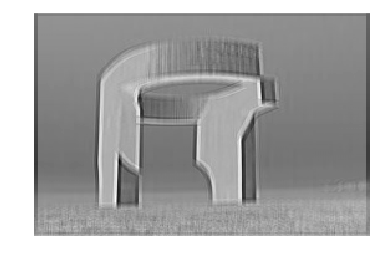

In [133]:
# Result of the application of the first kernel
plot_image(output[0, :, :, 0])
plt.show()

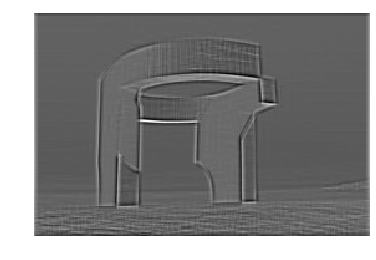

In [134]:
# Result of the application of the second kernel
plot_image(output[0, :, :, 1])
plt.show()

Finally, we illustrate the effect of an activation function (ReLU) on a convolved image. It further emphasises the most prominent features of the images. Remember the ReLU function is simply max(x,0)

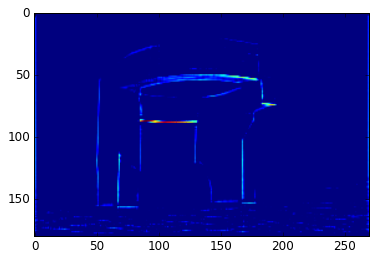

In [135]:
# We define the relu function
apply_relu = tf.nn.relu(X)

# We apply the activation function on the ouput of the second filter (output[0, :, :, 1])
with  tf.Session(config=config) as sess:
    image_relu = sess.run(apply_relu, feed_dict={X:  output[0, :, :, 1].reshape((1,height, width,1))})
 
# The result of the application of the function is shown
plt.imshow(image_relu.reshape((height,width)))  # plot the output for the 1st image



In [136]:
print(output[0,:,:,1])

[[-115.         -230.         -345.         ..., -363.         -240.         -117.        ]
 [   0.         -115.         -230.         ..., -243.         -119.            5.        ]
 [ 115.            0.         -115.         ..., -124.            1.          126.        ]
 ..., 
 [  83.66666412   28.33334732  -71.66667175 ..., -124.99999237
   -70.99998474    9.00000763]
 [  36.33333969  -28.99998856 -168.33332825 ..., -162.33332825
   -92.99998474  -10.99999619]
 [ -43.99998856 -164.33332825 -317.         ..., -190.33332825
  -106.00000763   -5.00000763]]


## Exercise 3

For the image loaded in the next cell, creates a convolutional layer with three filters of size 5x5 and the following conditions.

1. The first filter is a vertical filter (value 1 in the matrix)
2. The second filter is a main diagonal filter (a line from (0,0) to (4,4)) (value -1 in the matrix)
3. The third filter is a filter with random values between zero and 1

Execute the layer and show the convolved images.


Suggestion: Reuse the previous code specifying the characteristics of the new set of filters as done with fmap before.

257 375 3


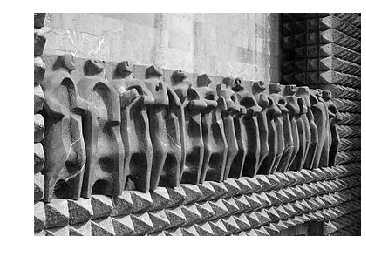

In [137]:

# We load the "Arantzazu.png" image 
image_C = scipy.misc.imread('cnn_images/Arantzazu.png', flatten=False, mode='RGB')

height, width, channels = image_C.shape

# We transform it to grayscale
image_grayscale = image_C.mean(axis=2).astype(np.float32)


print(height, width, channels)

plot_image(image_grayscale)
a_images = image_grayscale.reshape(1, height, width, 1)
plt.show()

In [138]:
my_fmap = np.zeros(shape=(5, 5, 1, 3), dtype=np.float32)

In [139]:
my_fmap[:, 2, 0, 0] = 1

In [140]:
for i in range(0,5):
    my_fmap[i, i, 0, 1] = -1

In [141]:
from random import uniform

for i in range(0,5):
    for j in range(0,5):
        my_fmap[i, j, 0, 2] = uniform(0.0,1.0)

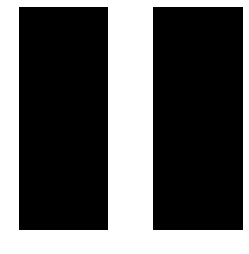

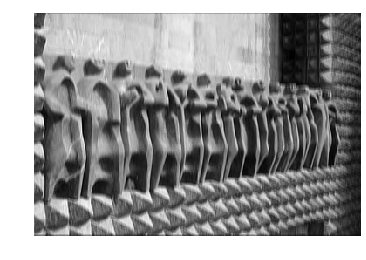

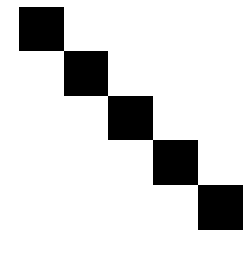

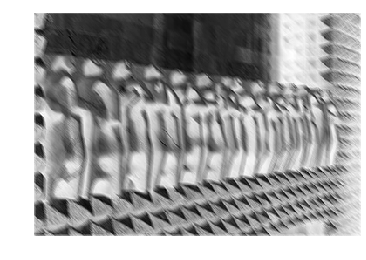

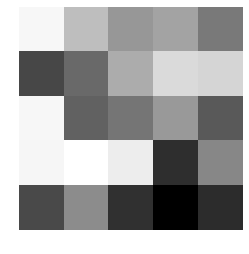

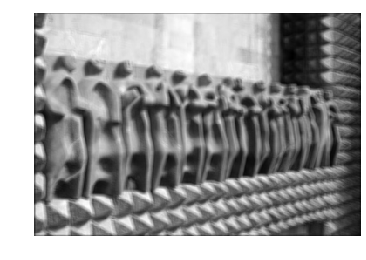

In [142]:
reset_graph()

X = tf.placeholder(tf.float32, shape=(None, height, width, 1))

config = tf.ConfigProto(device_count = {'GPU': 0})
feature_maps = tf.constant(my_fmap)
convolution = tf.nn.conv2d(X, feature_maps, strides=[1,1,1,1], padding="SAME")

with  tf.Session(config=config) as sess:
    output = convolution.eval(feed_dict={X: a_images})
    

for i in range(3):
    plot_image(my_fmap[:, :, 0, i])
    plt.show()
    plot_image(output[0, :, :, i])
    plt.show()

## Pooling layer

To define the pooling layer tensorflow provides functions tf.nn.max_pool() and tf.nn.ave_pool() and the parameters used are the same as for the convolutional layer (except that we do not need filters here). Therefore we do not discuss them here.

In [143]:

X = tf.placeholder(tf.float32, shape=(None, height, width, 1))

# The max_pool layer is defined using a kernel of size 2x2 and SAME padding
max_pool = tf.nn.max_pool(X, ksize=[1,2,2,1], strides=[1,1,1,1],padding="SAME")


with  tf.Session(config=config) as sess:
    output = sess.run(max_pool, feed_dict={X: a_images})
 


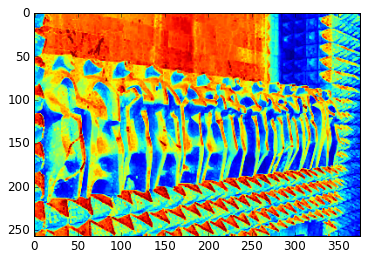

In [144]:
# We plot the effect of the maxpooling
mpool_image = output[0].reshape((height,width)).astype(np.uint8)
plt.imshow(mpool_image) 


## Convolutional Network for MNIST


In the next cell we define a convolutional network to solve the MNIST classification problem. This network has the following characteristics:

### Architecture

- Layer 1.  Convolutional. It has 16 filters of size 3. Stride is 1. Padding=SAME. The activation function of this layer is ReLU.
- Layer 2.  Convolutional. It has 24 filters of size 3. Stride is 2. Padding=SAME. The activation function of this layer is ReLU.
- Layer 3.  Maxpooling. Filter size = 2.  Stride is 2. Padding=VALID. 
- Layer 4.  Full layer. 64 neurons.  The activation function of this layer is ReLU.
- Output layer. Output function  Softmax to compute probability of 10 output values. 

### Other characteristicss
- Loss function: softmax_cross_entropy
- Optimizer:     Adam optimizer


Read carefully the network implementation.




In [150]:
# We define the characteristics of the input image 
height = 28
width = 28
channels = 1
n_inputs = height * width

# We define the parameters of the layers according to 
# description previously presented

conv1_fmaps = 16       #32
conv1_ksize = 3
conv1_stride = 1
conv1_pad = "SAME"

conv2_fmaps = 24     #64
conv2_ksize = 3
conv2_stride = 2
conv2_pad = "SAME"

pool3_fmaps = conv2_fmaps

n_fc1 = 64
n_outputs = 10


# In this part the network architecture is defined
reset_graph()

with tf.name_scope("inputs"):
    # Variable X is passed as a vector
    X = tf.placeholder(tf.float32, shape=[None, n_inputs], name="X")
    # It is reshaped to the tensor according to image size an channels
    X_reshaped = tf.reshape(X, shape=[-1, height, width, channels])
    # Class of each MNIST image
    y = tf.placeholder(tf.int32, shape=[None], name="y")

# The first layer is defined. Notice that the tensorflow function used
# is tf.layers.conv2d(). Also the parameters are those previously defined.


conv1 = tf.layers.conv2d(X_reshaped, filters=conv1_fmaps, kernel_size=conv1_ksize,
                         strides=conv1_stride, padding=conv1_pad,
                         activation=tf.nn.relu, name="conv1")

# The second layer is defined. Notice that the input of this layer is the output
# of the previous layer. You can check that conv1 has size 28x28 and conv2 has
# size 14x14 (Try to find out why)

conv2 = tf.layers.conv2d(conv1, filters=conv2_fmaps, kernel_size=conv2_ksize,
                         strides=conv2_stride, padding=conv2_pad,
                         activation=tf.nn.relu, name="conv2")

# The maxpool layer is defined. Notice that the  tf.nn.max_pool() is used to define the layer.
# Also, maxpool is applied to each of the conv2_fmaps filters, and since the inputs have size
# 14x14, Stride=2 and Padding=Valid, after applying maxpool we have pool3_fmaps filters
# of size (7x7). That is the reason while the output is reshaped (flattened) to (pool3_fmaps * 7 * 7)

with tf.name_scope("pool3"):
    pool3 = tf.nn.max_pool(conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding="VALID")
    pool3_flat = tf.reshape(pool3, shape=[-1, pool3_fmaps * 7 * 7])

# This is the full layer. From previous classes we already know function tf.layers.dense()
# used to define full layers. 
# The number of input and output units is the same (pool3_fmaps * 7 * 7)
with tf.name_scope("fc1"):
    fc1 = tf.layers.dense(pool3_flat, n_fc1, activation=tf.nn.relu, name="fc1")

# This is the output layer where the network produces a classification for each class
# The classification is used using the function softmax that we have studied in the previous lab
with tf.name_scope("output"):
    logits = tf.layers.dense(fc1, n_outputs, name="output")
    Y_proba = tf.nn.softmax(logits, name="Y_proba")

# The loss function and optimizers are defined as in previous labs.    
with tf.name_scope("train"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits, labels=y)
    loss = tf.reduce_mean(xentropy)
    optimizer = tf.train.AdamOptimizer()
    training_op = optimizer.minimize(loss)

# We define two functions to evaluate the quality of the network as classifier
# Correct computes, for a batch of observations, how many were correctly classified.
with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

# We define a saver 
with tf.name_scope("init_and_save"):
    init = tf.global_variables_initializer()
    saver = tf.train.Saver()

Reading MNIST dataset 

In [151]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("/tmp/data/")

Extracting /tmp/data/train-images-idx3-ubyte.gz
Extracting /tmp/data/train-labels-idx1-ubyte.gz
Extracting /tmp/data/t10k-images-idx3-ubyte.gz
Extracting /tmp/data/t10k-labels-idx1-ubyte.gz


We will train the network using batches of data of size BATCH_SIZE to avoid problems with the GPU memory. Also we will coumpute the accuracy in test set using batches. 

In [152]:
n_epochs = 3
IMAGE_SIZE = 28
NUM_CHANNELS = 1
BATCH_SIZE = 100
test_size = 10000

with  tf.Session(config=config) as sess:
    init.run()
    for epoch in range(n_epochs):
        for iteration in range(mnist.train.num_examples // BATCH_SIZE):
            X_batch, y_batch = mnist.train.next_batch(BATCH_SIZE)
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        acc_train = accuracy.eval(feed_dict={X: X_batch, y: y_batch})

        
        correct_pred = 0
        for iteration in range(mnist.test.num_examples // BATCH_SIZE):
            X_batch, y_batch = mnist.test.next_batch(BATCH_SIZE)
            correct_pred += np.sum(correct.eval(feed_dict={X: X_batch, y: y_batch}))
            #print(correct_pred)
            
        acc_test = (correct_pred / float(test_size))
        #acc_test = accuracy.eval(feed_dict={X: mnist.test.images, y: mnist.test.labels})
        print(epoch, "Train accuracy:", acc_train, "Test accuracy:", acc_test)

        #save_path = saver.save(sess, "./my_mnist_model")

0 Train accuracy: 0.98 Test accuracy: 0.9673
1 Train accuracy: 0.98 Test accuracy: 0.9795
2 Train accuracy: 0.97 Test accuracy: 0.9823


 Running the following two cells you can test the accuracy of the convolutional network for the fashion dataset.

In [153]:
from tensorflow.examples.tutorials.mnist import input_data
fashion = input_data.read_data_sets('fashion_data') 

Extracting fashion_data/train-images-idx3-ubyte.gz
Extracting fashion_data/train-labels-idx1-ubyte.gz
Extracting fashion_data/t10k-images-idx3-ubyte.gz
Extracting fashion_data/t10k-labels-idx1-ubyte.gz


In [ ]:
n_epochs = 10
IMAGE_SIZE = 28
NUM_CHANNELS = 1
BATCH_SIZE = 100
test_size = 10000

with  tf.Session(config=config) as sess:
    init.run()
    for epoch in range(n_epochs):
        for iteration in range(fashion.train.num_examples // BATCH_SIZE):
            X_batch, y_batch = fashion.train.next_batch(BATCH_SIZE)
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        acc_train = accuracy.eval(feed_dict={X: X_batch, y: y_batch})

        
        correct_pred = 0
        for iteration in range(fashion.test.num_examples // BATCH_SIZE):
            X_batch, y_batch = fashion.test.next_batch(BATCH_SIZE)
            correct_pred += np.sum(correct.eval(feed_dict={X: X_batch, y: y_batch}))
            #print(correct_pred)
            
        acc_test = (correct_pred / float(test_size))
        #acc_test = accuracy.eval(feed_dict={X: mnist.test.images, y: mnist.test.labels})
        print(epoch, "Train accuracy:", acc_train, "Test accuracy:", acc_test)

        #save_path = saver.save(sess, "./my_mnist_model")
    

0 Train accuracy: 0.84 Test accuracy: 0.8537
1 Train accuracy: 0.87 Test accuracy: 0.878
2 Train accuracy: 0.9 Test accuracy: 0.8872
3 Train accuracy: 0.9 Test accuracy: 0.8902
4 Train accuracy: 0.93 Test accuracy: 0.8876
5 Train accuracy: 0.93 Test accuracy: 0.8952


## Exercise 4

Merging datasets MNIST and Fashion, we will create a joint dataset of 20 classes, 20000 training instances, and 20000 test instances. Create and execute a convolutional neural network that classifies any image in one of the 20 classes. To test your network in the joint set of data, execute the following cell, but first you need to create the new network.

The CNN should have the following parameters.

### Architecture

- Layer 1.  Convolutional. It has 20 filters of size 5. Stride is 1. Padding=SAME. The activation function of this layer is ReLU.
- Layer 2.  Convolutional. It has 40 filters of size 2. Stride is 2. Padding=SAME. The activation function of this layer is ReLU.
- Layer 3.  Average pooling. Filter size = 2.  Stride is 2. Padding=VALID. 
- Layer 4.  Full layer. 64 neurons.  The activation function of this layer is ReLU.
- Output layer. Output function  Softmax to compute probability of 20 output values. 

### Other characteristicss
- Loss function: softmax_cross_entropy
- Optimizer:     Adam optimizer




In [ ]:
#  You can set the definition of your network in this cell and run it in the following cell











In [190]:
n_epochs = 10
IMAGE_SIZE = 28
NUM_CHANNELS = 1
BATCH_SIZE = 100
test_size = 20000

with  tf.Session(config=config) as sess:
    init.run()
    for epoch in range(n_epochs):
        for iteration in range(fashion.train.num_examples // BATCH_SIZE):
          
            X_batch_mnist, y_batch_mnist = mnist.train.next_batch(BATCH_SIZE)
            X_batch_fashion, y_batch_fashion = fashion.train.next_batch(BATCH_SIZE)
            # We concatenate the batch from the two datasets
            X_batch = np.vstack((X_batch_mnist,X_batch_fashion))
            # The labels of the fashion dataset will be now from 10 to 19
            y_batch = np.hstack((y_batch_mnist,10+y_batch_fashion))
                
            
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        acc_train = accuracy.eval(feed_dict={X: X_batch, y: y_batch})

        
        correct_pred = 0
        for iteration in range(fashion.test.num_examples // BATCH_SIZE):     
            # For computing the accuracy in test, we add the number of correct
            # predictions for the two sets
            
            X_batch, y_batch = mnist.test.next_batch(BATCH_SIZE)
            correct_pred += np.sum(correct.eval(feed_dict={X: X_batch, y: y_batch}))
            X_batch, y_batch = fashion.test.next_batch(BATCH_SIZE)
            correct_pred += np.sum(correct.eval(feed_dict={X: X_batch, y: 10+y_batch}))
            
        acc_test = (correct_pred / float(test_size))
        #acc_test = accuracy.eval(feed_dict={X: mnist.test.images, y: mnist.test.labels})
        print(epoch, "Train accuracy:", acc_train, "Test accuracy:", acc_test)

0 Train accuracy: 0.935 Test accuracy: 0.9063
1 Train accuracy: 0.93 Test accuracy: 0.92215
2 Train accuracy: 0.94 Test accuracy: 0.92845
3 Train accuracy: 0.935 Test accuracy: 0.9275
4 Train accuracy: 0.96 Test accuracy: 0.9348
5 Train accuracy: 0.985 Test accuracy: 0.93525
6 Train accuracy: 0.965 Test accuracy: 0.93755
7 Train accuracy: 0.945 Test accuracy: 0.93785
8 Train accuracy: 0.955 Test accuracy: 0.93875
9 Train accuracy: 0.97 Test accuracy: 0.9428


## Exercise 5

The clustering organization in Exercise 2 might not be very accurate since two pictures in the same category may be represented by different variables. It makes more sense to measure how close are concepts predicted by the CNN. We can measure the similarity between classes using word similarity (you will learn more about these concepts in two weeks). Now, you can use the implementations shown in the following cells to compute of matrix of similarity between images, and cluster the images using this similarity.
For example, images whose words are closer, will be closer in the representation. 


If you get an error running the following cell, uncomment the last two lines and comment the first.
Then run the cell, in the "corpora" column select "wordnet"


In [ ]:
from nltk.corpus import wordnet as wn
# import nltk
# nltk.download()


In [ ]:
from nltk.corpus import wordnet as wn

def word_similarity(w1,w2):
    similarity = 0
    w1sets = wn.synsets(w1)
    w2sets = wn.synsets(w2)
    #print(w1sets,w2sets)
    
    pairs_meanings = []
    for i in w1sets:
        for j in w2sets:
            #pairs_meanings.append(i.path_similarity(j))
            pairs_meanings.append(i.wup_similarity(j))

    similarity = np.nanmax(np.array(pairs_meanings, dtype=np.float64))
    return similarity

word1 = 'rose'
word2 = 'horse'
ws = word_similarity(word1,word2)
print('The similarity between rose and horse: ', ws)

word1 = 'rose'
word2 = 'sunflower'
ws = word_similarity(word1,word2)
print('The similarity between rose and sunflower: ', ws)

word1 = 'dog'
word2 = 'horse'
ws = word_similarity(word1,word2)
print('The similarity between dog and horse: ', ws)

word1 = 'zebra'
word2 = 'horse'
ws = word_similarity(word1,word2)
print('The similarity between zebra and horse: ', ws)